In [8]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#tensorflow objects
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, FullSpaceNNFormulation, \
FullSpaceSmoothNNFormulation, ReducedSpaceSmoothNNFormulation, ReluBigMFormulation,\
ReluComplementarityFormulation, ReluPartitionFormulation
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader
import omlt
from keras.layers import PReLU

from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pyomo.environ as pyo
import omlt
from omlt import OmltBlock
from omlt.neuralnet import *
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader

In [4]:
alphas = [1.5, 1, 0.5, 0, -0.5, -1, -1.5]
leakynets = []

for alpha in alphas:
    model = Sequential(name=f'leakynet_{alpha}')
    model.add(Input(1))
    model.add(Dense(1, activation=LeakyReLU(alpha=alpha), kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.add(Dense(1, kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.compile(optimizer=Adam(), loss='mse')
    leakynets.append(model)

alphas = [1.5, 1, 0.5, 0, -0.5, -1, -1.5]
prelu_nets = []

for alpha in alphas:
    model = Sequential(name=f'prelu_net_{alpha}')
    model.add(Input(1))
    model.add(Dense(1))
    model.add(PReLU(alpha_initializer=alpha))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    prelu_nets.append(model)



In [12]:
# Input data
inputs = np.array([1, 2, 3, 4, 5])

# Create empty dictionary to store outputs
outputs_dict = {}

# Feed inputs to each neural network and plot their outputs
for model in leakynets:
    outputs = model.predict(inputs)
    outputs_dict[model.name] = outputs.flatten()

for model in prelu_nets:
    outputs = model.predict(inputs)
    outputs_dict[model.name] = outputs.flatten()

1/1 [==============================] - 0s 36ms/step


In [10]:
# function to evaluate a point on the neuralnet using OMLT
def OMLTcheck(net, inputs, outputs):
    # Create a dictionary with the field names and corresponding arrays
    data = {'x': inputs, 'y': outputs.flatten()}

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

    #retrieve input 'x' and output 'y' from the dataframe
    x = df["x"]
    y = df["y"]

    mean_data = df.mean(axis=0)
    std_data = df.std(axis=0)
    df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
    df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

    y_predict_scaled_para = net.predict(x=df['x_scaled'])
    y_predict_para = y_predict_scaled_para*(std_data['y']) + mean_data['y']

    #create a single plot with the original data and each neural network's predictions
    fig,ax = plt.subplots(1,figsize = (8,8))
    ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
    ax.plot(x,y_predict_para,linewidth = 3.0,linestyle="dotted",label = "parametric-relu")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    #create an omlt scaling object
    scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                        factor_inputs=[std_data['x']],
                        offset_outputs=[mean_data['y']],
                        factor_outputs=[std_data['y']])
    
    #create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
    input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                    (max(df['x']) - mean_data['x'])/std_data['x'])};
    print(scaler)
    print("Scaled input bounds: ",input_bounds)

    net_relu_para = keras_reader.load_keras_sequential(net,scaler,input_bounds)

    model5_bigm = pyo.ConcreteModel()
    model5_bigm.x = pyo.Var(initialize = 0)
    model5_bigm.y = pyo.Var(initialize = 0)
    model5_bigm.obj = pyo.Objective(expr=(model5_bigm.y))
    model5_bigm.nn = OmltBlock()

    formulation5_bigm = ReluBigMFormulation(net_relu_para)
    model5_bigm.nn.build_formulation(formulation5_bigm)

    @model5_bigm.Constraint()
    def connect_inputs(mdl):
        return mdl.x == mdl.nn.inputs[0]

    @model5_bigm.Constraint()
    def connect_outputs(mdl):
        return mdl.y == mdl.nn.outputs[0]

    #model5_bigm.nn.layers['139763200661440'].c1.deactivate()
    status_5_bigm = pyo.SolverFactory('gams:cbc').solve(model5_bigm, tee=True)
    model5_bigm.pprint()
    solution_5_bigm = (pyo.value(model5_bigm.x),pyo.value(model5_bigm.y))

    #print out model size and solution values
    print("ReLU BigM Solution:")
    print("# of variables: ",model5_bigm.nvariables())
    print("# of constraints: ",model5_bigm.nconstraints())
    print("x = ", solution_5_bigm[0])
    print("y = ", solution_5_bigm[1])

    #net - parametric relu 
    plt.plot(x,y_predict_para,linewidth = 3.0,linestyle="dotted",color = "green")
    plt.title("parametric-relu")
    plt.scatter([solution_5_bigm[0]],[solution_5_bigm[1]],color = "blue",s = 300, label="bigm")
    plt.legend()
    plt.show()
    plt.close()


1/1 [==============================] - 0s 37ms/step


NameError: name 'x' is not defined

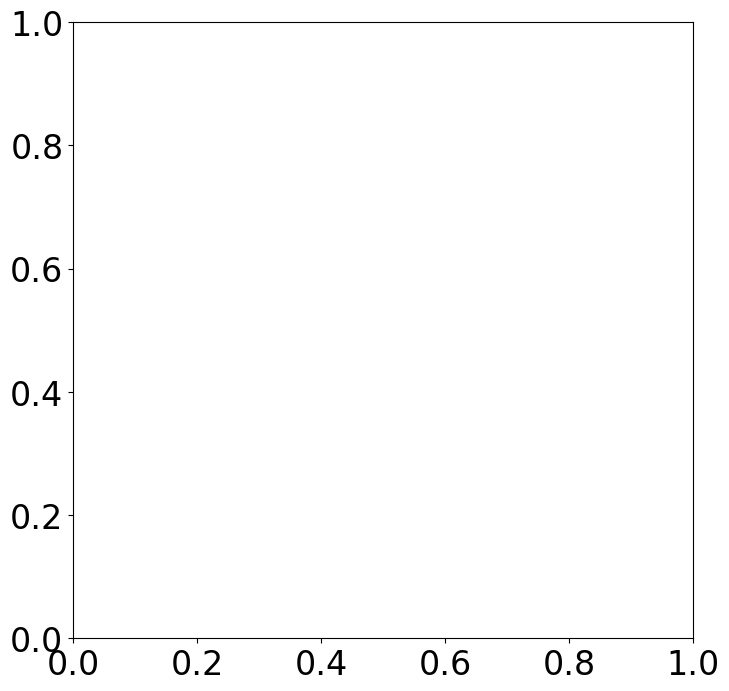

In [13]:
OMLTcheck(prelu_nets[0],inputs,outputs_dict['leakynet_1.5'])